In [2]:
import numpy as np
import pandas as pd
import lxml
import matplotlib.pyplot as plt
from scipy import optimize as op
from cvxopt import solvers
from cvxopt import matrix

## Lets get the list of S&P components from Wikipedia. We only keep the ticker symbols that have been publicaly traded over the last three year.

In [3]:
import pandas as pd

# There are 2 tables on the Wikipedia page
# we want the first table

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]

df = first_table
df.head()
my_stocks = df['Symbol'].values.tolist()
n = len(my_stocks)
my_stocks.remove('BRK.B')
my_stocks.remove('BF.B')
my_stocks.remove('CARR')
my_stocks.remove('LUMN')
my_stocks.remove('OTIS')
my_stocks.remove('VNT')
my_stocks.remove('CTVA')
my_stocks.remove('FOXA')
my_stocks.remove('DOW')
my_stocks.remove('FOX')
my_stocks.remove('VIAC')


## Lets get the stock market data over last three year from yahoo

In [22]:
import urllib.request
url2018 = ['https://query1.finance.yahoo.com/v7/finance/download/']
url2018.append('?period1=1514764800&period2=1611100800&interval=1d&events=history&includeAdjustedClose=true')

my_dict = {}
for symbol in my_stocks:
  try:
    my_dict[symbol] = pd.read_csv(symbol+'.csv')
  except:
    try:
      url = url2018[0]+symbol+url2018[1]
      urllib.request.urlretrieve(url,symbol+'.csv')
      my_dict[symbol] = pd.read_csv(symbol+'.csv')
    except:
      pass

n = len(my_dict)
T_all = my_dict['AAPL'].shape[0]

my_dict['AAPL'].tail()

,Date,Open,High,Low,Close,Adj Close,Volume
762,2021-01-12,128.500000,129.690002,126.860001,128.800003,128.800003,91951100
763,2021-01-13,128.759995,131.449997,128.490005,130.889999,130.889999,88636800
764,2021-01-14,130.800003,131.000000,128.759995,128.910004,128.910004,90221800
765,2021-01-15,128.779999,130.220001,127.000000,127.139999,127.139999,111598500
766,2021-01-19,127.779999,128.710007,126.940002,127.830002,127.830002,90296400


## Lets trade only every other day

In [10]:
trade_freq = 2
all_stocks = np.zeros([n,T_all])
for i, symbol in enumerate(my_stocks):
    try:
        all_stocks[i,:] =  np.float32(my_dict[symbol].Open) 
    except:
        print("some problem for data of",symbol)
all_times =  my_dict[symbol].Date

stocks = all_stocks[:,::trade_freq]
times = all_times.iloc[::trade_freq]
T = len(stocks[0])

## Parameter Free Expert

In [11]:
def pfe(prices, cut_off = 0.01):

  n = len(prices)
  T = len(prices[0]) 

  # initialization
  x = np.ones(n)/n
  f_digit = np.zeros(T)

  sum_g_tild = np.zeros(n)
  sum_g_w = np.zeros(n)
  x_0 = np.ones(n)/n
  # iterations
  for t in range(T-1):
      w = sum_g_tild /(t+T/2)*(1+sum_g_w)
      x =  x_0 * np.maximum(w, 0)
      if np.sum(x) > 0:
          x = x / np.sum(x)
      else:
          x = x_0

      r = prices[:,t+1]/prices[:,t]
      grad = r/np.dot(x, r)

      g_tild = grad - np.dot(grad, x)
      g_tild[w<0] = np.maximum(g_tild[w<0], 0)

      sum_g_tild += g_tild
      sum_g_w += g_tild
      if t == 0:
        f_digit[0] = 0
      else:
        # digitalized wealth
        present = x> cut_off
        x_digit = x[present]
        r_digit = r[present]
        f_digit[t] = -np.log(np.dot(x_digit,r_digit)/sum(x_digit))

  return x, np.cumsum(-f_digit[1:])

## ONS

In [12]:
def project(y, A):
  n = y.size

  P = matrix(A, tc='d')
  q = matrix(-2*np.matmul(y, A), tc='d')
  G = matrix(-np.eye(n), tc='d')
  h = matrix(np.zeros(n), tc='d')
  A = matrix(np.ones([1,n]), tc='d')
  b = matrix([1], tc='d')

  solvers.options['show_progress'] = False
  sol = solvers.qp(P,q,G,h,A,b)
  return np.array(sol['x']).reshape(-1)

def ons(prices):
  n = len(prices)
  T = len(prices[0]) 
  # parameters:
  alpha = 0.5

  # algorithm
  G = np.sqrt(n)/alpha
  gamma = 1/8/G
  epsilon = 1/gamma**2

  # Initialization
  A = epsilon*np.eye(n)
  x = np.ones(n)/n
  f = np.zeros(T)

  # iterations
  for t in range(T-1):
    r = prices[:,t+1]/prices[:,t]
    grad = - r/np.dot(x, r)
    A = A + np.outer(grad, grad)
    y = x - 1/gamma * np.linalg.solve(A, grad)
    x = project(y, A)

    # log wealth
    f[t] = - np.log(np.dot(x,r))


  return x, np.cumsum(-f[1:])

In [17]:
def portfolio_plot(x,tickers,cut_off,ax1):
  biggest = np.argsort(x)
  sizes = []
  labels = []
  for i in biggest[::-1]:
    if x[i] > cut_off:
      sizes.append(x[i]*100)
      labels.append(tickers[i])
  ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  return ax1

## Running all algorithms

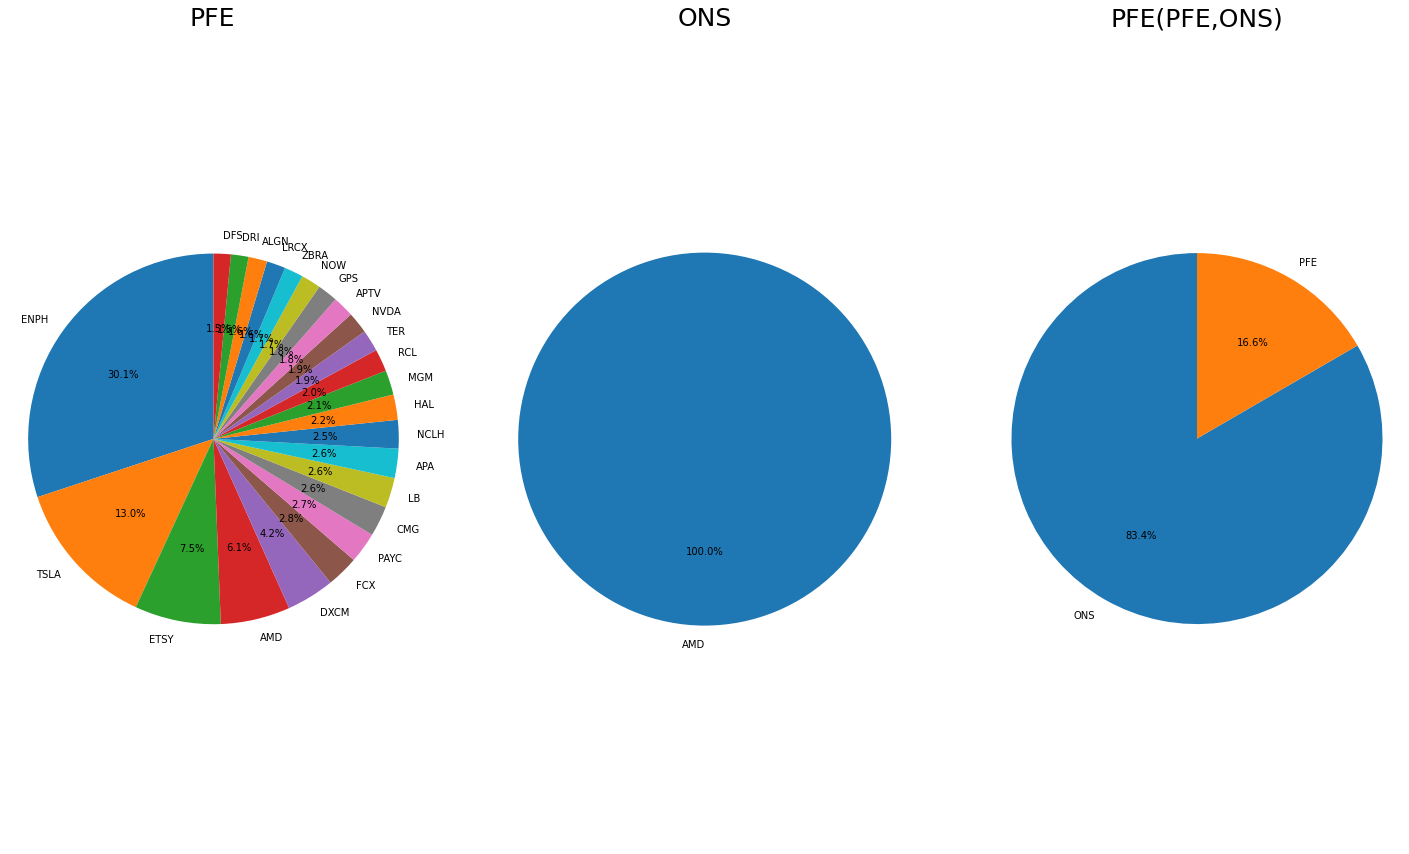

In [18]:
fig1, ax1 = plt.subplots(1,3)
fig1.set_size_inches(25, 15)

cut_off = 0.007
# Parameter Free Expert
x, log_wealth_expert = pfe(stocks, cut_off)
ax1[0] = portfolio_plot(x,my_stocks,cut_off,ax1[0])
ax1[0].set_title('PFE', {'fontsize': 25})

# ONS 
x, log_wealth_ons = ons(stocks)
ax1[1] = portfolio_plot(x,my_stocks,cut_off,ax1[1])
ax1[1].set_title('ONS', {'fontsize': 25})

# ONS + Parameter Free Expert
my_etf = ['ONS','PFE']
alg1 = np.exp(log_wealth_expert).reshape(1,-1)
alg2 = np.exp(log_wealth_ons).reshape(1,-1)
etf = np.concatenate((alg1, alg2), axis = 0)
x , log_wealth_expert_ons = pfe(etf)
ax1[2] = portfolio_plot(x, my_etf, cut_off, ax1[2])
ax1[2].set_title('PFE(PFE,ONS)', {'fontsize': 25})

plt.show()


## Back Test

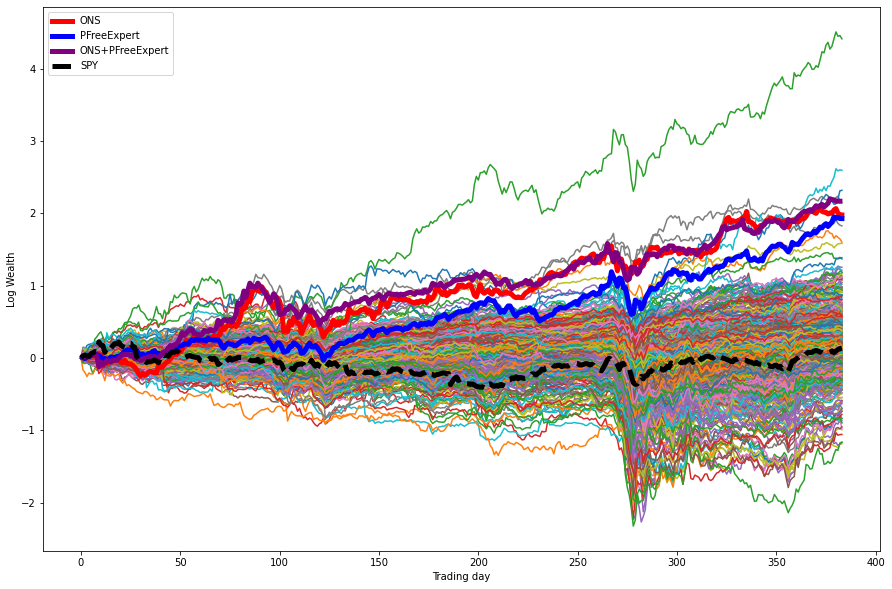

In [23]:
## Visualization
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
for i, symbol in enumerate(my_stocks):
    ax.plot(range(T),np.log(stocks[i,:]) - np.log(stocks[i,0]))


ax.plot(range(1,T), log_wealth_ons , 'r' , linewidth=5, label='ONS')
ax.plot(range(1,T), log_wealth_expert , 'b' , linewidth=5, label='PFreeExpert')
ax.plot(range(1,T-1), log_wealth_expert_ons , 'purple' , linewidth=5, label='ONS+PFreeExpert')
ax.plot(range(T), np.log(stocks[2,:])- np.log(stocks[2,0]), '--k' , linewidth=5, label='SPY')

ax.legend()
ax.set_xlabel('Trading day')
ax.set_ylabel('Log Wealth')
plt.show()


In [21]:
print("Date is now: ",times.iloc[-1])

Date is now:  2021-01-19
